In [21]:
!pip install -r ../requirements.txt

In [22]:
from glob import glob
import os
import numpy as np
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from skimage.morphology import binary_closing
from skimage.filters import gaussian
import cv2
from matplotlib import pyplot as plt
from math import sqrt
from math import cos, sin, pi
from random import randint

In [23]:
class Point:
    def __init__(self, x: int, y: int):
        self.x = x
        self.y = y


class Segment:
    def __init__(self, _p1: Point, _p2: Point):
        self.p1 = _p1
        self.p2 = _p2


def convert_sm_to_px(x_old: int, y_old: int, size: tuple):
    size_x = size[1]
    size_y = size[0]
    x_a4 = 21
    y_a4 = 29.7
    x = 100 / x_a4 * x_old
    new_x = size_x * (x / 100)
    y = 100 / y_a4 * y_old
    new_y = size_y * (y / 100)
    return Point(int(new_x), int(new_y))


def update_maxX(max_old: int, size: tuple):
    size_x = size[1]
    x_a4 = 21
    x = 100 / x_a4 * max_old
    new_x = size_x * (x / 100)
    return new_x


def distance(p1: Point, p2: Point):
    return sqrt((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2)


class Contour:
    def __init__(self, contour, polygon=False, img_size=(0, 0, 0)):
        if not polygon:
            self.cv_contour = contour
            self.contour = []
            self.max_x = 0
            list_contour = contour.tolist()
            for i in range(len(list_contour)):
                x1 = list_contour[i][0][0]
                y1 = list_contour[i][0][1]
                i_next = i + 1
                if i_next == len(list_contour):
                    i_next = 0
                x2 = list_contour[i_next][0][0]
                y2 = list_contour[i_next][0][1]
                x = max(x1, x2)
                if x > self.max_x:
                    self.max_x = x
                p1 = Point(x1, y1)
                p2 = Point(x2, y2)
                s = Segment(p1, p2)
                self.contour.append(s)
        else:
            self.cv_contour = np.array(contour)
            self.contour = []
            self.max_x = 0
            list_contour = contour[0]
            for i in range(len(list_contour)):
                x1 = list_contour[i][0]
                y1 = list_contour[i][1]
                i_next = i + 1
                if i_next == len(list_contour):
                    i_next = 0
                x2 = list_contour[i_next][0]
                y2 = list_contour[i_next][1]
                x = max(x1, x2)
                if x > self.max_x:
                    self.max_x = x
                p1 = convert_sm_to_px(x1, y1, img_size)
                p2 = convert_sm_to_px(x2, y2, img_size)
                s = Segment(p1, p2)
                self.contour.append(s)
            self.max_x = update_maxX(self.max_x, img_size)

    def recalc_maxX(self):
        for s in self.contour:
            p1 = s.p1
            p2 = s.p2
            x1 = p1.x
            x2 = p2.x
            x = max(x1, x2)
            if x > self.max_x:
                self.max_x = x
        return self.max_x

    def get_cv_contour(self):
        new_cv_contour = []
        for s in self.contour:
            p1 = s.p1
            p2 = s.p2
            new_cv_contour.append([p1.x, p1.y])
            new_cv_contour.append([p2.x, p2.y])
        self.cv_contour = np.array([new_cv_contour])
        return self.cv_contour

    def get_moments(self):
        # calculate moments for each contour
        M = cv2.moments(self.get_cv_contour())
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return (cX, cY)

    def get_min_dist_to_segments_from_point(self, p: Point):
        x = p.x
        y = p.y
        min = 1e9
        for s in self.contour:
            x_c = int((s.p1.x + s.p2.x) / 2)
            y_c = int((s.p1.y + s.p2.y) / 2)
            p1 = Point(x, y)
            p2 = Point(x_c, y_c)
            dst = distance(p1, p2)
            if dst < min:
                min = dst
        return min

    def get_average_dist_to_segments_from_center(self, p: Point):
        xM, yM = self.get_moments()
        sum = 0
        for s in self.contour:
            x_c = int((s.p1.x + s.p2.x) / 2)
            y_c = int((s.p1.y + s.p2.y) / 2)
            p1 = Point(xM, yM)
            p2 = Point(x_c, y_c)
            sum += distance(p1, p2)
        return int(sum / len(self.contour))

In [24]:
# converting grades to radians
def grad_ro_rad(grad: int):
    return grad * pi / 180


# transfer contour cnt to x_diff and y_diff
def transfer_contour(cnt: Contour, x_diff: int, y_diff: int):
    for s in cnt.contour:
        p1 = s.p1
        x = p1.x
        y = p1.y
        new_x = x + x_diff
        new_y = y + y_diff
        s.p1.x = new_x
        s.p1.y = new_y

        p2 = s.p2
        x = p2.x
        y = p2.y
        new_x = x + x_diff
        new_y = y + y_diff
        s.p2.x = new_x
        s.p2.y = new_y


# rotate contour cnt to angle alpha
def rotate_contour(cnt: Contour, alpha: int):
    cX, cY = cnt.get_moments()
    for s in cnt.contour:
        p1 = s.p1
        x = p1.x - cX
        y = p1.y - cY
        new_x = x * cos(alpha) - y * sin(alpha)
        new_y = x * sin(alpha) + y * cos(alpha)
        s.p1.x = int(new_x + cX)
        s.p1.y = int(new_y + cY)

        p2 = s.p2
        x = p2.x - cX
        y = p2.y - cY
        new_x = x * cos(alpha) - y * sin(alpha)
        new_y = x * sin(alpha) + y * cos(alpha)
        s.p2.x = int(new_x + cX)
        s.p2.y = int(new_y + cY)


# calculating orientation area
def area(p1: Point, p2: Point, p3: Point):
    return (p2.x - p1.x) * (p3.y - p1.y) - (p2.y - p1.y) * (p3.x - p1.x)


# if segment s1 intersect segment s2 (projections)
def intersect_axis(a, b, c, d):
    if a > b:
        k = a
        a = b
        b = k
    if c > d:
        k = c
        c = d
        d = k
    return max(a, c) <= min(b, d)


# if segment s1 intersect segment s2
def intersect_segments(s1: Segment, s2: Segment):
    a = s1.p1
    b = s1.p2
    c = s2.p1
    d = s2.p2
    return intersect_axis(a.x, b.x, c.x, d.x) and \
           intersect_axis(a.y, b.y, c.y, d.y) and \
           area(a, c, d) * area(b, c, d) <= 0 and \
           area(c, a, b) * area(d, a, b) <= 0


# if contour cnt1 intersect contour cnt2
def intersect_contours(cnt1: Contour, cnt2: Contour):
    for s1 in cnt1.contour:
        for s2 in cnt2.contour:
            if intersect_segments(s1, s2):
                return True
    return False


# if s2.node lay on s1
def intersect_node(s1: Segment, s2: Segment):
    if distance(s1.p1, s2.p1) + distance(s1.p2, s2.p1) == distance(s1.p1, s1.p2):
        return True, s2.p1.y < s2.p2.y
    elif distance(s1.p1, s2.p2) + distance(s1.p2, s2.p2) == distance(s1.p1, s1.p2):
        return True, s2.p2.y < s2.p1.y
    return False, False


#  Nested point p into contour cnt?
def point_in_polygon(p: Point, cnt: Contour):
    max_x = cnt.recalc_maxX()
    s = Segment(p, Point(max_x + 1, p.y))
    inter_count = 0
    for s_i in cnt.contour:
        node_flag, true_node_inter = intersect_node(s, s_i)
        if node_flag:
            if true_node_inter:
                inter_count += 1
            continue
        elif intersect_segments(s, s_i):
            inter_count += 1
    if inter_count % 2 == 0:
        return False
    else:
        return True


#  Nested contour cnt1 into contour cnt2?
def contour_in_contours(cnt1: Contour, cnts: list, cnt_num: int):
    not_nested_count = 0
    for i, cnt in enumerate(cnts):
        if i == cnt_num:
            continue
        for s in cnt1.contour:
            p1 = s.p1
            p2 = s.p2
            if not point_in_polygon(p1, cnt) or not point_in_polygon(p2, cnt):
                not_nested_count += 1
                break
    if not_nested_count == len(cnts) - 1:
        return False
    return True


#  Nested rectangle cnt1 into rectangle сnt2?
def nested_poly(cnt1, cnt2):
    x1, y1, w1, h1 = cv2.boundingRect(cnt1)
    x2, y2, w2, h2 = cv2.boundingRect(cnt2)
    if x1 > x2 and y1 > y2 and x1 + w1 < x2 + w2 and y1 + h1 < y2 + h2:
        return True
    return False


# if one contour intersects other contours
def intersect_other_contours(cnt: Contour, cnts: list, contour_num: int):
    for i, other_cnt in enumerate(cnts):
        if i == contour_num:
            continue
        if intersect_contours(cnt, other_cnt):
            return True
    return False


#  optimal transfer contour to random position in polygon, all nodes will be in polygon
def opt_transfer_to_poly(cnt: Contour, poly: Contour):
    x, y, w, h = cv2.boundingRect(poly.get_cv_contour())
    new_x = randint(x, x + w)
    new_y = randint(y, y + h)
    p = Point(new_x, new_y)
    xM, yM = cnt.get_moments()
    x_diff = p.x - xM
    y_diff = p.y - yM
    xM += x_diff
    yM += y_diff
    transfer_contour(cnt, x_diff, y_diff)
    while not point_in_polygon(p, poly) or intersect_contours(cnt, poly):
        new_x = randint(x, x + w)
        new_y = randint(y, y + h)
        p = Point(new_x, new_y)
        x_diff = p.x - xM
        y_diff = p.y - yM
        xM += x_diff
        yM += y_diff
        transfer_contour(cnt, x_diff, y_diff)

    max_transfers = 1000
    step_x = 10
    step_y = 10
    transfer_count = 0
    init_direct = 0
    while transfer_count < max_transfers:
        #  generate step  (x and y range ) and transfer contour (all nodes will be in polygon)
        direct = generate_step_to_transfer(step_x, step_y, cnt, poly, init_direct)
        transfer_count += 1
        if init_direct != direct:
            break


#  transfer contour to random position in polygon, all nodes will be in polygon
def transfer_to_poly(cnt: Contour, poly: Contour):
    x, y, w, h = cv2.boundingRect(poly.get_cv_contour())
    new_x = randint(x, x + w)
    new_y = randint(y, y + h)
    p = Point(new_x, new_y)
    xM, yM = cnt.get_moments()
    x_diff = p.x - xM
    y_diff = p.y - yM
    xM += x_diff
    yM += y_diff
    transfer_contour(cnt, x_diff, y_diff)
    while not point_in_polygon(p, poly) or intersect_contours(cnt, poly):
        new_x = randint(x, x + w)
        new_y = randint(y, y + h)
        p = Point(new_x, new_y)
        x_diff = p.x - xM
        y_diff = p.y - yM
        xM += x_diff
        yM += y_diff
        transfer_contour(cnt, x_diff, y_diff)
    return p


#  generate step (x and y range ) for contour (all nodes will be in polygon)
def generate_step_to_transfer(step_x, step_y, cnt: Contour, poly: Contour, direct: int):
    if direct == 0:
        transfer_contour(cnt, step_x, 0)
        if intersect_contours(cnt, poly):
            transfer_contour(cnt, -step_x, 0)
            direct = 1
        else:
            return direct
    if direct == 1:
        transfer_contour(cnt, 0, step_y)
        if intersect_contours(cnt, poly):
            transfer_contour(cnt, 0, -step_y)
            direct = 2
        else:
            return direct
    if direct == 2:
        transfer_contour(cnt, -step_x, 0)
        if intersect_contours(cnt, poly):
            transfer_contour(cnt, step_x, 0)
            direct = 3
        else:
            return direct
    if direct == 3:
        transfer_contour(cnt, 0, -step_y)
        if intersect_contours(cnt, poly):
            transfer_contour(cnt, 0, step_y)
            direct = 0
        else:
            return direct

    return direct


In [25]:
red_bgr_color = (0, 0, 255)
contours_curve_dim = 10


def show_img(img):
    plt.imshow(img, cmap='gray', interpolation='bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def save_img(img, cnts: list, poly: Contour, path):
    for cnt in cnts:
        cv2.drawContours(img, cnt.get_cv_contour(), -1, red_bgr_color, contours_curve_dim)
    cv2.drawContours(img, poly.get_cv_contour(), -1, red_bgr_color, contours_curve_dim)
    plt.imshow(img, cmap='gray', interpolation='bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.savefig(path)


def draw_contours_and_poly(img, cnts: list, poly: Contour):
    for cnt in cnts:
        cv2.drawContours(img, cnt.get_cv_contour(), -1, red_bgr_color, contours_curve_dim)
    cv2.drawContours(img, poly.get_cv_contour(), -1, red_bgr_color, contours_curve_dim)
    show_img(img)


In [26]:
# we pre-process all images
def preprocess_data(img):
    show_img(img)
    # convert to gray gradations
    img_gray = rgb2gray(img)
    # gaussian blur to remove noise
    img_gray = gaussian(img_gray, sigma=3, channel_axis=True)
    # we perform binarization using the threshold to the otsu
    thresh_otsu = threshold_otsu(img_gray)
    otsu = img_gray <= thresh_otsu
    # apply binary closure to close gaps
    close_otsu = binary_closing(otsu, footprint=np.ones((20, 20)))
    # for reading opencv2
    cv_close_otsu = img_as_ubyte(close_otsu)
    show_img(close_otsu)
    # find contours in processed image
    contours, hierarchy = cv2.findContours(cv_close_otsu, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # sort our contours that find bigest area
    sort_contours = list(reversed(sorted(contours, key=cv2.contourArea)))
    obj_contours = []
    obj_areas = []
    # at the processing stage, cases were noticed when small outliers were present inside other objects,
    # they were removed by checking whether they lie strictly inside other object contours
    for check_contour in sort_contours:
        rubbish = False
        for contour in sort_contours:
            if nested_poly(check_contour, contour):
                rubbish = True
                break
        if not rubbish:
            obj_contours.append(check_contour)
            obj_areas.append(cv2.contourArea(check_contour))

    # due to possible noise in the images,
    # very small objects stood out somewhere at the edges,
    # they were removed through small area values
    average_obj_area = sum(obj_areas) / len(obj_areas)
    i = 0
    while i != len(obj_areas):
        if obj_areas[i] < average_obj_area / 10:
            del obj_areas[i]
            del obj_contours[i]
        else:
            i += 1

    print("Object contours count: {}\n".format(len(obj_contours)))
    return obj_contours


In [27]:
def get_test_poly():
    poly_1 = [[3, 19], [17, 19], [17, 29], [3, 29]]  # sm
    # poly_2 = [[3, 1], [19, 1], [19, 25], [4, 25]]  # sm
    poly_3 = [[5, 1], [17, 1], [17, 22], [5, 20]]  # sm
    poly_4 = [[2, 10], [17, 10], [18, 25], [3, 27]]  # sm
    poly_5 = [[2, 9], [19, 9], [18, 25], [1, 27]]  # sm
    poly_6 = [[9, 1], [15, 1], [15, 25], [5, 25]]  # sm
    poly_7 = [[1, 3], [20, 2], [19, 28], [2, 29]]  # sm
    test_poly = [poly_1, poly_3, poly_4, poly_5, poly_6, poly_7]
    return test_poly


def get_test_data(path):
    titles = []
    images = []
    format_length = 4

    for image_path in glob(os.path.join(path, "*.jpg")):
        tittle = os.path.basename(image_path)[:-format_length]
        if len(tittle) > 1 and tittle[-2] == '_':
            continue
        # if tittle[0] != '4' or tittle[0] != '4':
        #     continue
        if tittle[0] == '8' or tittle[0] == '2':
            continue
        titles.append(tittle)
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images.append(image_bgr)
    return images, titles

In [28]:
# start main algorithm
def placer_start(contours_np, img, polygon_sm, date_path, title, iter):
    # for debug
    back_path = os.path.join(os.getcwd(), '../data', 'dataset', 'one')
    image_bgr = cv2.imread(os.path.join(back_path, "back.jpg"), cv2.IMREAD_COLOR)
    # use our class for contours
    contours = []
    for cnt in contours_np:
        new_cnt = Contour(cnt)
        contours.append(new_cnt)
    polygon = Contour(polygon_sm, True, img.shape)

    # to avoid hardcode, we declare variables before the start of the function
    rotate_angle = 45
    max_rot = int(360 / rotate_angle)
    max_transfers = 20
    max_step_x = int(img.shape[1] / 20)
    max_step_y = int(img.shape[0] / 20)
    process_contours = []
    # place the contours of objects in turn
    for contour_num, cnt in enumerate(contours):
        process_contours.append(cnt)
        # draw_contours_and_poly(image_bgr.copy(), process_contours, polygon)
        # replace out contour to new position in polygon, all nodes will be in polygon
        if contour_num == 0:
            opt_transfer_to_poly(cnt, polygon)
        else:
            transfer_to_poly(cnt, polygon)
        # for debug
        # cv2.drawContours(img2, cnt.get_cv_contour(), -1, red_bgr_color, contours_curve_dim)
        # cv2.drawContours(img2, polygon.get_cv_contour(), -1, red_bgr_color, contours_curve_dim)
        # show_img(img2)

        # draw_contours_and_poly(image_bgr.copy(), process_contours, polygon)
        # for the first contour, it makes no sense to check its intersection with other contours
        if contour_num == 0:
            continue
        contour_in_contour_flag = False
        non_opt_conf_flag = False
        # for nested polygon it makes no sense to check rotations
        if not contour_in_contours(cnt, process_contours, contour_num):
            # try rotation until successful conformation
            rot_count = 0
            while intersect_contours(cnt, polygon) or intersect_other_contours(cnt, process_contours,
                                                                               contour_num):
                if rot_count < max_rot:
                    rotate_contour(cnt, grad_ro_rad(rotate_angle))
                    rot_count += 1
                else:
                    non_opt_conf_flag = True
                    break
        else:
            contour_in_contour_flag = True
        # if we could not find the correct conformation
        if contour_in_contour_flag or non_opt_conf_flag or contour_in_contours(cnt, process_contours, contour_num):
            transfer_count = 0
            # move one step and start to rotate, so a certain number of times
            direct = 0
            while transfer_count < max_transfers:
                #  generate step  (x and y range ) and transfer contour (all nodes will be in polygon)
                direct = generate_step_to_transfer(max_step_x, max_step_y, cnt, polygon, direct)
                # for debug
                # cv2.drawContours(img2, cnt.get_cv_contour(), -1, red_bgr_color, contours_curve_dim)
                # cv2.drawContours(img2, polygon.get_cv_contour(), -1, red_bgr_color, contours_curve_dim)
                # show_img(img2)


                # draw_contours_and_poly(image_bgr.copy(), process_contours, polygon)

                if intersect_other_contours(cnt, process_contours, contour_num):
                    rot_count = 0
                    # try rotation until successful conformation
                    while intersect_contours(cnt, polygon) or intersect_other_contours(cnt, process_contours, contour_num):
                        if rot_count < max_rot:
                            rotate_contour(cnt, grad_ro_rad(rotate_angle))
                            rot_count += 1
                        else:
                            break
                    # by rotations got the correct position
                    if rot_count < max_rot and not contour_in_contours(cnt, process_contours, contour_num):
                        break
                elif contour_in_contours(cnt, process_contours, contour_num):
                    transfer_count += 1
                    continue
                else:
                    break
                transfer_count += 1
            if transfer_count == max_transfers:
                return False

    # for debug
    # img_copy = img.copy()
    draw_contours_and_poly(image_bgr.copy(), process_contours, polygon)
#     save_img(image_bgr.copy(), process_contours, polygon, date_path + "/" + title + "_" + str(iter) + '_res.png')
    # show_img(img_copy)
    return True


Let's go!!!!

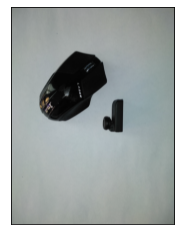

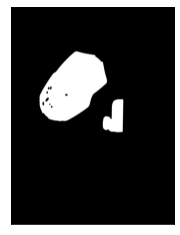

Object contours count: 2



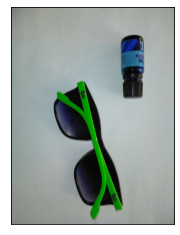

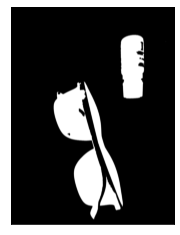

Object contours count: 2



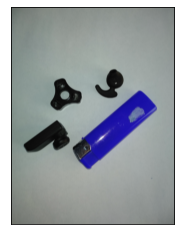

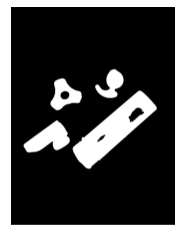

Object contours count: 4



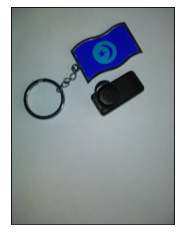

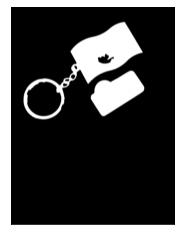

Object contours count: 2



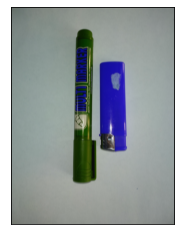

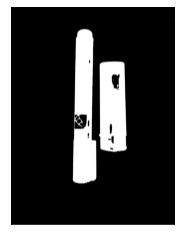

Object contours count: 2



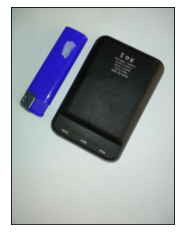

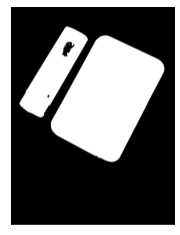

Object contours count: 2



In [29]:
# use relative paths
date_path = os.path.join(os.getcwd(), '../data', 'dataset', 'mark')
# read data
images, titles = get_test_data(date_path)
poly = get_test_poly()
fail_count = 0
success_count = 0
total_count = 0
contouts = []
for id, image in enumerate(images):
    cnts = preprocess_data(image)
    contouts.append(cnts)

Image name: 1 Iteration: 0


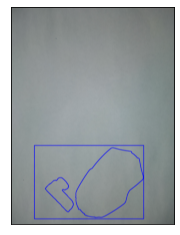

True!
Image name: 1 Iteration: 1


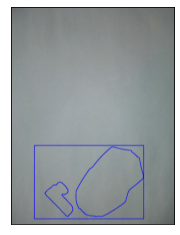

True!
Image name: 1 Iteration: 2


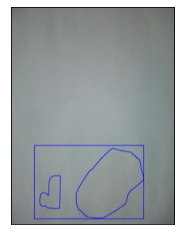

True!
Image name: 1 Iteration: 3


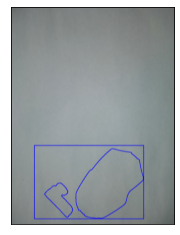

True!
Image name: 1 Iteration: 4


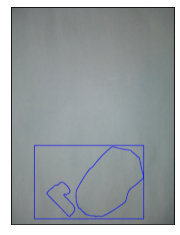

True!
Image name: 3 Iteration: 0
False!
Image name: 3 Iteration: 1


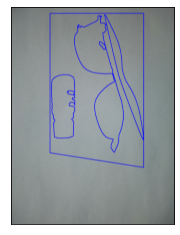

True!
Image name: 3 Iteration: 2


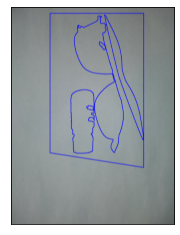

True!
Image name: 3 Iteration: 3
False!
Image name: 3 Iteration: 4


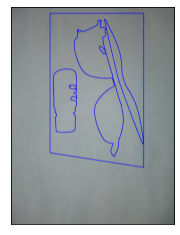

True!
Image name: 4 Iteration: 0
False!
Image name: 4 Iteration: 1


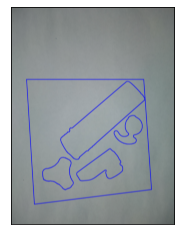

True!
Image name: 4 Iteration: 2
False!
Image name: 4 Iteration: 3


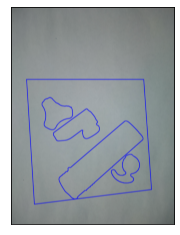

True!
Image name: 4 Iteration: 4


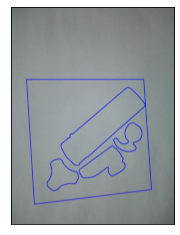

True!
Image name: 5 Iteration: 0


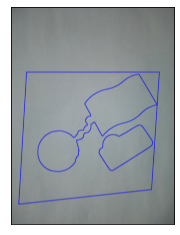

True!
Image name: 5 Iteration: 1


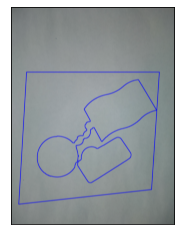

True!
Image name: 5 Iteration: 2


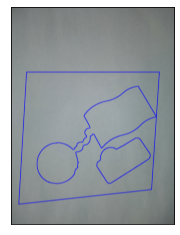

True!
Image name: 5 Iteration: 3


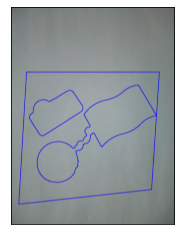

True!
Image name: 5 Iteration: 4


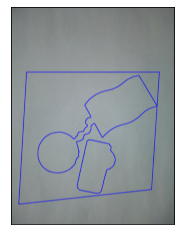

True!
Image name: 6 Iteration: 0


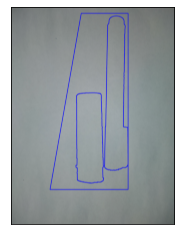

True!
Image name: 6 Iteration: 1


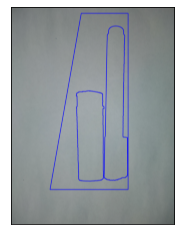

True!
Image name: 6 Iteration: 2


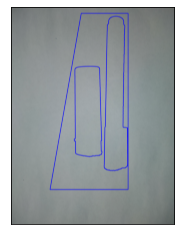

True!
Image name: 6 Iteration: 3


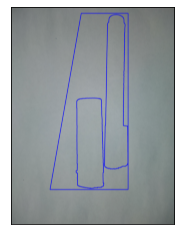

True!
Image name: 6 Iteration: 4


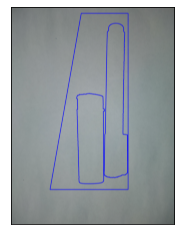

True!
Image name: 7 Iteration: 0


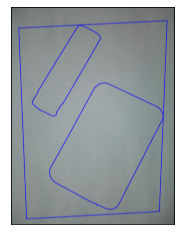

True!
Image name: 7 Iteration: 1
False!
Image name: 7 Iteration: 2
False!
Image name: 7 Iteration: 3
False!
Image name: 7 Iteration: 4


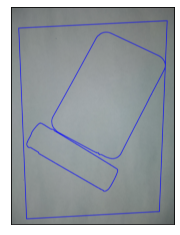

True!
Success rate: 76.66666666666667%
Failure rate: 23.333333333333332%


In [30]:
# we pre-process all images and start placer for every image
for id, image in enumerate(images):
    cnts = contouts[id]
    for iter in range(5):
        print("Image name: " + titles[id] + " Iteration: " + str(iter))
        status = placer_start(cnts, image, [poly[id]], date_path, titles[id], iter)
        if status:
            success_count += 1
            print("True!")
        else:
            fail_count += 1
            print("False!")
        total_count += 1
print("Success rate: " + str(success_count / total_count * 100) + "%")
print("Failure rate: " + str(fail_count / total_count * 100) + "%")

## Success rate: 76.66666666666667%
## Failure rate: 23.333333333333332%